In [1]:
import argparse
import os
import numpy as np
#from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
#from keras.layers.merge import add, concatenate
#from keras.models import Model
import struct
import cv2
import generator

Using TensorFlow backend.
C:\Users\plj585\Anaconda3\envs\CT-detection\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plj585\Anaconda3\envs\CT-detection\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plj585\Anaconda3\envs\CT-detection\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plj585\Anacond

In [106]:
import cv2
path = "train/images/TL 20110605 160317.JPEG"
img = cv2.imread(path)

TypeError: Image data of dtype object cannot be converted to float

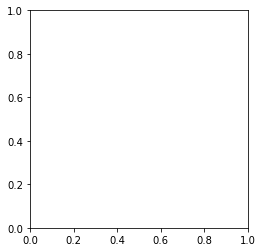

In [105]:
from matplotlib import pyplot as plt
plt.imshow(img)
plt.show()

In [6]:
cv2.imshow('image', img)
while(True):
    k = cv2.waitKey(33)
    if k == -1:  # if no key was pressed, -1 is returned
        continue
    else:
        break
cv2.destroyWindow('image')

In [9]:
dir_name = "train/images/"
pics= os.listdir(dir_name)
img = cv2.imread(dir_name+pics[i])
for i in range(len(pics)):
    path = dir_name + pics[i]
    img = cv2.imread(path)

In [8]:
i=0
dir_name = "train/images/"
pics= os.listdir(dir_name)
dir_name+pics[i]


'train/images/BR 20100308 095752.JPEG'

In [22]:
import argparse
import os
import numpy as np
import json
from voc import parse_voc_annotation
from yolo import create_yolov3_model, dummy_loss
from generator import BatchGenerator
from utils.utils import normalize, evaluate, makedirs
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from callbacks import CustomModelCheckpoint, CustomTensorBoard
from utils.multi_gpu_model import multi_gpu_model
import tensorflow as tf
import keras
from keras.models import load_model

train_annot_folder = "train/annotations/"
train_image_folder = "train/images/"
train_cache = ""
labels = ["animal", "human"]

In [23]:
from voc import parse_voc_annotation
train_ints, train_labels = parse_voc_annotation(train_annot_folder, train_image_folder, train_cache, labels)

In [31]:
config_path = "config.json"
with open(config_path) as config_buffer:    
        config = json.loads(config_buffer.read())


from train import create_training_instances
train_ints, valid_ints, labels, max_box_per_image = create_training_instances(
        config['train']['train_annot_folder'],
        config['train']['train_image_folder'],
        config['train']['cache_name'],
        config['valid']['valid_annot_folder'],
        config['valid']['valid_image_folder'],
        config['valid']['cache_name'],
        config['model']['labels']
    )


valid_annot_folder not exists. Spliting the trainining set.
Seen labels: 	{'human': 10455, 'animal': 1392}

Given labels: 	['animal', 'human']


In [32]:
train_generator = generator.BatchGenerator(
        instances           = train_ints, 
        anchors             = config['model']['anchors'],   
        labels              = labels,        
        downsample          = 32, # ratio between network input's size and network output's size, 32 for YOLOv3
        max_box_per_image   = max_box_per_image,
        batch_size          = config['train']['batch_size'],
        min_net_size        = config['model']['min_input_size'],
        max_net_size        = config['model']['max_input_size'],   
        shuffle             = True, 
        jitter              = 0.3, 
        norm                = normalize
    )

In [61]:
i=0
for r in train_generator:
    [x_batch, t_batch, yolo_1, yolo_2, yolo_3], [dummy_yolo_1, dummy_yolo_2, dummy_yolo_3] = r
    i+=1
    if i>5:
        break

resizing:  256 256


In [110]:
import cv2
path = "train/jpeg/TL 20110605 160317.JPEG"
img = cv2.imread(path)

In [111]:
img
image = img[:,:,::-1]

image_h, image_w, _ = image.shape

dw = 0.3 * image_w;
dh = 0.3 * image_h;
net_w = 256
net_h = 256

In [71]:
from utils.image import apply_random_scale_and_crop, random_distort_image, random_flip, correct_bounding_boxes

In [96]:
new_ar = (image_w + np.random.uniform(-dw, dw)) / (image_h + np.random.uniform(-dh, dh))
scale = np.random.uniform(0.25, 2);

if (new_ar < 1):
    new_h = int(scale * net_h)
    new_w = int(net_h * new_ar)
else:
    new_w = int(scale * net_w)
    new_h = int(net_w / new_ar)

dx = int(np.random.uniform(0, net_w - new_w))
dy = int(np.random.uniform(0, net_h - new_h))
im_sized = apply_random_scale_and_crop(image, new_w, new_h, net_w, net_h, dx, dy)

resizing:  192 192
resizing:  128 128
resizing:  256 256


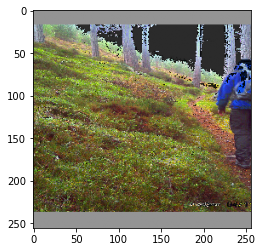

In [170]:
#im_sized = random_distort_image(im_sized)
i=0
stop +=1
for r in train_generator:
    [x_batch, t_batch, yolo_1, yolo_2, yolo_3], [dummy_yolo_1, dummy_yolo_2, dummy_yolo_3] = r
    i+=1
    if i>stop:
        break

plt.imshow(x_batch[0])
plt.show()

In [145]:
stop = 0

In [15]:
from imgaug import augmenters as iaa

train_aug = iaa.SomeOf((1, 3), [  # Random number between 0, 3
    iaa.Fliplr(0.5),  # Horizontal flips                     0.01
    # Random channel increase and rotation 0.03
    iaa.Add((-5, 5)),  # Overall Brightness                   0.04
    iaa.Multiply((0.95, 1.05), per_channel=0.2),  # Brightness multiplier per channel    0.05
    iaa.Sharpen(alpha=(0.1, 0.75), lightness=(0.85, 1.15)),  # Sharpness                            0.05
    iaa.WithColorspace(to_colorspace='HSV', from_colorspace='RGB',  # Random HSV increase                  0.09
                       children=iaa.WithChannels(0, iaa.Add((-30, 30)))),
    iaa.WithColorspace(to_colorspace='HSV', from_colorspace='RGB',
                       children=iaa.WithChannels(1, iaa.Add((-30, 30)))),
    iaa.WithColorspace(to_colorspace='HSV', from_colorspace='RGB',
                       children=iaa.WithChannels(2, iaa.Add((-30, 30)))),
    iaa.AddElementwise((-10, 10)),  # Per pixel addition                   0.11
    iaa.CoarseDropout((0.0, 0.02), size_percent=(0.02, 0.25)),  # Add large black squares              0.13
    iaa.GaussianBlur(sigma=(0.1, 1.0)),  # GaussianBlur                         0.14
    iaa.Grayscale(alpha=(0.1, 1.0)),  # Random Grayscale conversion          0.17
    iaa.Dropout(p=(0, 0.1), per_channel=0.2),  # Add small black squares              0.17
    iaa.AdditiveGaussianNoise(scale=(0.0, 0.05 * 255), per_channel=0.5),
    # Add Gaussian per pixel noise         0.26
    iaa.ElasticTransformation(alpha=(0, 1.0), sigma=0.25),  # Distort image by rearranging pixels  0.70
    iaa.LinearContrast((0.75, 1.5)),  # Contrast Normalization               0.95
    iaa.weather.Clouds(),
    iaa.weather.Fog(),
    iaa.weather.Snowflakes()
], random_order=True)

seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])



In [120]:
scale = np.random.uniform(0.25, 2)
from utils.image import apply_random_scale_and_crop, random_distort_image, random_flip, correct_bounding_boxes

new_w = int(128)
new_h = int(128)


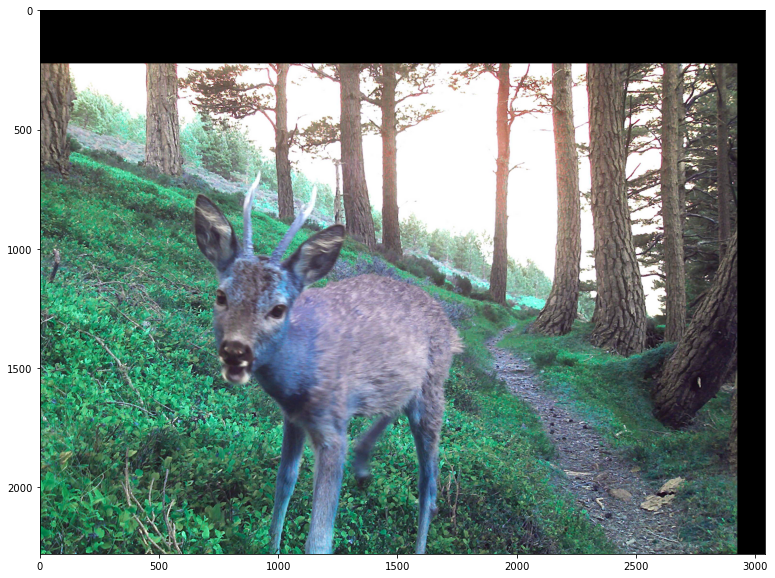

In [121]:
one = iaa.Sequential([
   iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})
])

#altered = train_aug.augment_image(image)
altered = one.augment_image(img)

plt.figure(figsize=(20,10)) 
plt.imshow(altered)
plt.show()

In [122]:
#Saves an altered image

filename = 'example_images/Translate.jpg'

# Using cv2.imwrite() method
# Saving the image
cv2.imwrite(filename, altered)

True

In [251]:
from PIL import Image
with Image.open('train/images/BR 20100308 095752.JPEG') as im:
    im.rotate(45).show()